In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 1. LSTM

In [2]:
data = pd.read_csv('hourly_clusters.csv')
data.head()

,time,0,1,2,3
0,2012-01-01 00:00:00,1.145077e+17,1.125080e+17,1.772093e+17,8.779628e+15
1,2012-01-01 01:00:00,1.426715e+17,1.338765e+17,1.796054e+17,1.009013e+16
2,2012-01-01 02:00:00,1.383707e+17,1.289111e+17,1.772971e+17,1.189987e+16
3,2012-01-01 03:00:00,1.314110e+17,1.331608e+17,1.840901e+17,1.143953e+16
4,2012-01-01 04:00:00,1.273598e+17,1.353437e+17,1.920048e+17,9.742502e+15


In [28]:
values = data['0'].values
values = values.reshape(-1, 1)

In [29]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler_values = scaler.fit_transform(values)
scaler = StandardScaler()
scaler_values = scaler.fit_transform(values.reshape(-1, 1))

In [30]:
train_size = int(len(scaler_values) * 0.8)
test_size = len(scaler_values) - train_size
train_data, test_data = scaler_values[0:train_size], scaler_values[train_size:]

In [31]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [32]:
seq_length = 24
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=200, verbose=1)

test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

y_test_actual = scaler.inverse_transform(y_test)

Epoch 1/200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3108
Epoch 2/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1095
Epoch 3/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0944
Epoch 4/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0917
Epoch 5/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0889
Epoch 6/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0870
Epoch 7/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0850
Epoch 8/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0820
Epoch 9/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0869
Epoch 10/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0814
Epoch 11/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0856
Epoch 12/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0867
Epoch 13/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0847
Epoch 14/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0857
Epoch 15/200
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step -

In [33]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_actual, test_predictions)
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Absolute Percentage Error: 2.7041972297958616%


### 2. SARIMA

In [4]:
# define a fuction to check stationarilty
def stationary(data):
    result = adfuller(data)
    if result[1] > 0.05:
        print('Time series is not stationary.')
    else:
        print('Time series is stationary.')

In [5]:
stationary(data['0'])

Time series is not stationary.


In [6]:
data_diff = data['0'].diff().dropna()
stationary(data_diff)

Time series is stationary.


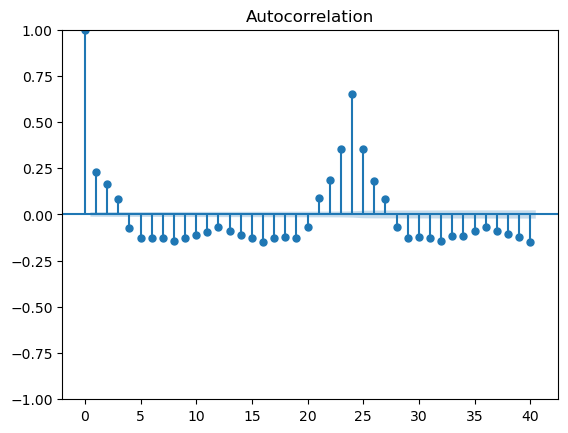

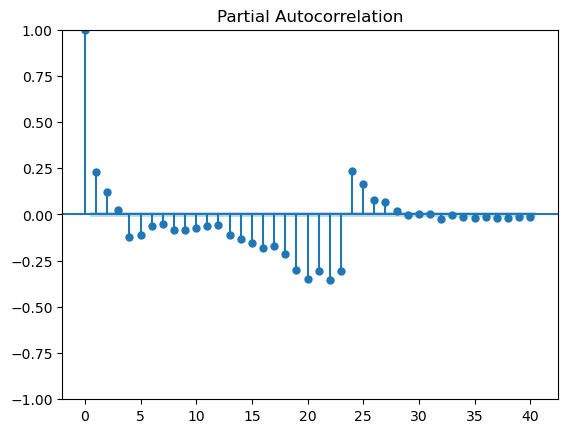

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff, lags=40)
plt.show()

plot_pacf(data_diff, lags=40)
plt.show()

In [8]:
# obvious seasonality
data_seasonal_diff = data_diff.diff(24).dropna()
stationary(data_diff)

Time series is stationary.


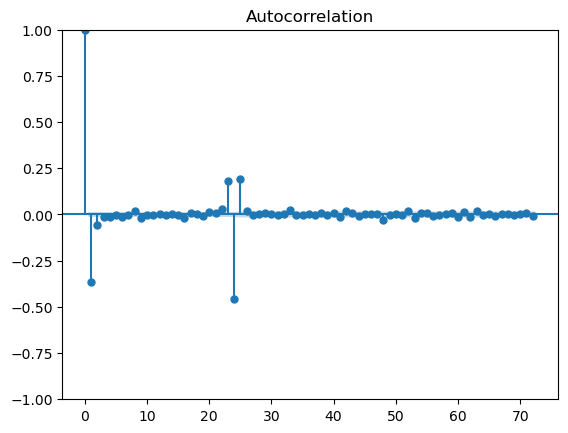

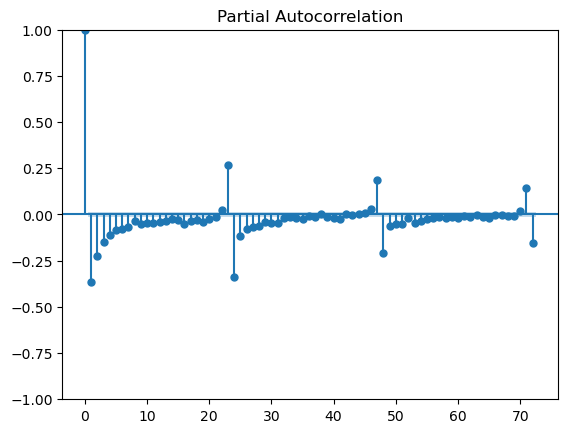

In [9]:
plot_acf(data_seasonal_diff, lags=72)
plt.show()

plot_pacf(data_seasonal_diff, lags=72)  
plt.show()

In [10]:
train_size = int(len(data_seasonal_diff) * 0.8)
train_data = data_seasonal_diff.iloc[:train_size]
test_data = data_seasonal_diff.iloc[train_size:]

In [14]:
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 24)

model = SARIMAX(
    train_data, 
    order=order,
    seasonal_order=seasonal_order
)
results = model.fit(disp=False)

forecast_steps = len(test_data)
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean 
forecast_ci = forecast.conf_int() 

test_actual = test_data
test_predictions = forecast_mean

mape = mean_absolute_percentage_error(test_actual, test_predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%') 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Absolute Percentage Error (MAPE): 113.18%


### 3. Prophet

In [23]:
df = data[['time', '0']]
df.rename(columns={'time': 'ds', '0': 'y'}, inplace=True)
df.head()

/var/folders/kg/q3b1npp54mn6cwl_d28bdvnh0000gn/T/ipykernel_14317/3672083760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'time': 'ds', '0': 'y'}, inplace=True)


,ds,y
0,2012-01-01 00:00:00,1.145077e+17
1,2012-01-01 01:00:00,1.426715e+17
2,2012-01-01 02:00:00,1.383707e+17
3,2012-01-01 03:00:00,1.314110e+17
4,2012-01-01 04:00:00,1.273598e+17


In [24]:
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [25]:
from prophet import Prophet

model = Prophet()

model.fit(train_data)

12:19:30 - cmdstanpy - INFO - Chain [1] start processing
12:19:33 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future = model.make_future_dataframe(periods=len(test_data), freq='H')  

forecast = model.predict(future)

test_predictions = forecast.iloc[-len(test_data):]['yhat'] 
test_actual = test_data['y']  

/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [27]:
mape = mean_absolute_percentage_error(test_actual, test_predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 3.93%
